In [40]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
def denormalize_image(img):
    """
    img = (h, w, c)
    """
    offset=(0.485, 0.456, 0.406)
    scale=(0.229, 0.224, 0.225)
    img[:, :, 0] += offset[0]
    img[:, :, 1] += offset[1]
    img[:, :, 2] += offset[2]
    
    img[:, :, 0] *= scale[0]
    img[:, :, 1] *= scale[1]
    img[:, :, 2] *= scale[2]
    return img

2023-10-20 19:06:10.134282: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/gilbreth/cuda-toolkit/cuda-11.2.0/extras/CUPTI/lib64:/apps/gilbreth/cuda-toolkit/cuda-11.2.0/lib64:/apps/spack/gilbreth/apps/intel-mpi/2017.1.132-intel-17.0.1-p7yx74h/compilers_and_libraries_2017.1.132/linux/mpi/intel64/lib:/apps/spack/gilbreth/apps/intel-mpi/2017.1.132-intel-17.0.1-p7yx74h/compilers_and_libraries_2017.1.132/linux/mpi/mic/lib:/apps/spack/gilbreth/apps/intel-parallel-studio/cluster.2017.1-intel-17.0.1-2off4ih/itac/2017.1.024/intel64/slib:/apps/spack/gilbreth/apps/intel-parallel-studio/cluster.2017.1-intel-17.0.1-2off4ih/compilers_and_libraries_2017.1.132/linux/compiler/lib/intel64:/apps/spack/gilbreth/apps/intel-parallel-studio/cluster.2017.1-intel-17.0.1-2off4ih/compilers_and_libraries_2017.1.132/linux/compiler

In [30]:
npy_path = "/depot/qqiu/data/vishal/tf-maskformer/predicted_npy"
which_img = 0
image_1 = np.load(os.path.join(npy_path, "input_img_"+str(which_img)+".npy"))
target_masks = np.load(os.path.join(npy_path, "target_masks_"+str(which_img)+".npy"))
predicted_masks = np.load(os.path.join(npy_path, "output_masks_"+str(which_img)+".npy"))
target_labels = np.load(os.path.join(npy_path, "target_labels_"+str(which_img)+".npy"))
predicted_labels = np.load(os.path.join(npy_path, "output_labels_"+str(which_img)+".npy"))
#print shape of all the loaded arrays
print("image shape :", image_1.shape)
print("Target mask shape :", target_masks.shape)
print("Predicted mask shape :", predicted_masks.shape)
print("Targete labels shape :", target_labels.shape)
print("Predicted labels shape :", predicted_labels.shape)

image shape : (1, 640, 640, 3)
Target mask shape : (1, 100, 640, 640)
Predicted mask shape : (1, 160, 160, 100)
Targete labels shape : (1, 100)
Predicted labels shape : (1, 100)


In [31]:
print("Target labels :", target_labels)
print("Predicted labels :", predicted_labels)

Target labels : [[  1.   1.  40.  42.  42.  44.  45.  46.  46.  46.  46.  51.  51.  51.
   52.  61.  70.  70.  72.  93. 111. 117. 121. 122. 123. 124. 129. 132.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]]
Predicted labels : [[ 40 132  42  42  40  45  76  46  56  46  93  94  46  46  43  84  40  70
  132 115  72  46  86  45 133  45 119  45  45 122  42 123 133 110 112  40
  113  46  45  40  87  57 116  40  45  40  46  72  45  45  46 105  42 121
   45  45 122  40  42  45  44  40  44  45  88  57  40  40  46 128  45 129
   40   1  46  46  46  40 119  46  46  59  25  85  44  46 121  45  44  46
   45  44  46  42  40  61   1  70  46  27]]


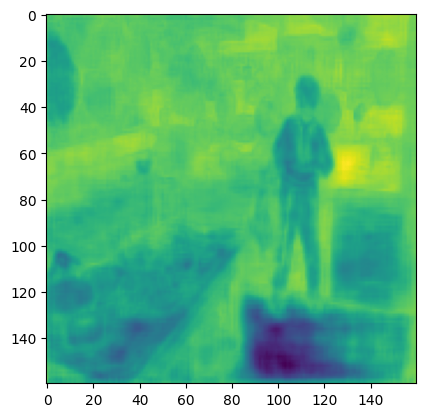

In [38]:
# post processing of masks
mask_pred_b_resized =  tf.image.resize(predicted_masks, (640, 640), method=tf.image.ResizeMethod.BILINEAR)
mask_pred_b_sigmoid = tf.keras.activations.sigmoid(mask_pred_b_resized)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


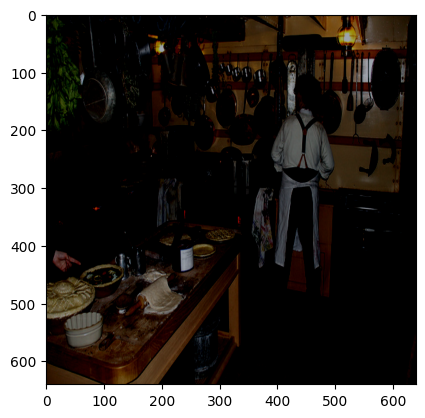

In [35]:
plt.imshow(denormalize_image(image_1[0]))